In [3]:
import torch 
import numpy as np
import matplotlib.pyplot as plt


In [5]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)


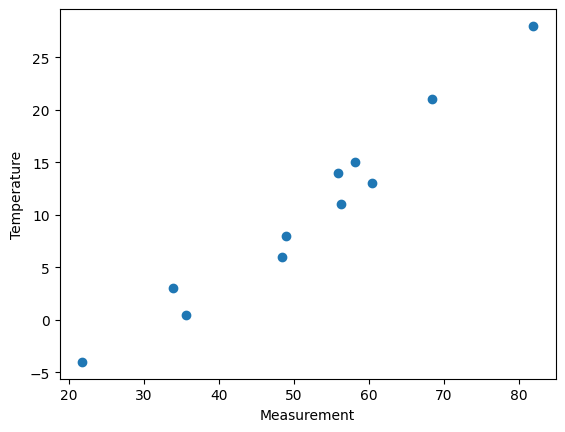

In [8]:
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.xlabel('Measurement')
plt.ylabel('Temperature')
plt.show()


In [9]:
def model(t_u, w, b): 
    return w * t_u + b

def loss_fn(t_p, t_c): 
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()


In [10]:
w = torch.ones(())
b = torch.zeros(())
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [11]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [12]:
delta = .1
loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

loss_rate_of_change_b = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)
b = b - learning_rate * loss_rate_of_change_b


In [13]:
def dloss_fn(t_p, t_c): 
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])


In [17]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c, print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

    return params

In [25]:
t_un = 0.1 * t_u 

params = training_loop(n_epochs = 5000, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_un, t_c = t_c, print_params = False)

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


Text(0, 0.5, 'Temperature (°Celsius)')

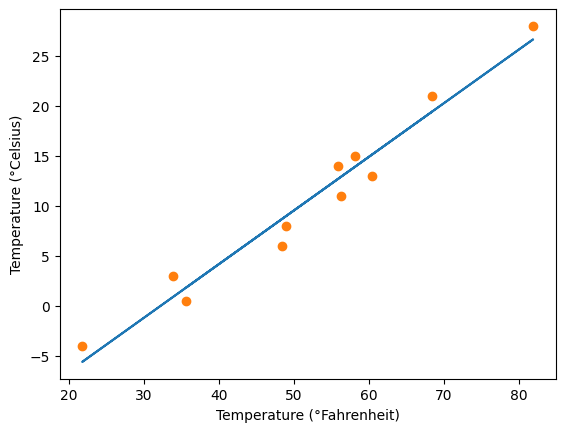

In [26]:
t_p = model(t_un, *params)

plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")


In [28]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
print(params.grad )

None


In [29]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()
params.grad

tensor([4517.2969,   82.6000])

In [30]:
if params.grad is not None:
    params.grad.zero_()

In [32]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c): 
    for epoch in range(1, n_epochs+1): 
        if params.grad is not None: 
            params.grad.zero_()
        
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        with torch.no_grad(): 
            params -= learning_rate * params.grad
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
        
    return params



In [33]:
training_loop(n_epochs=5000, learning_rate=1e-2, params=torch.tensor([1.0, 0.0], requires_grad=True), t_u=t_un, t_c=t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [36]:
import torch.optim as optim

params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)
optimizer.zero_grad()
loss.backward()
optimizer.step()
params

tensor([1.0008e+00, 1.0640e-04], requires_grad=True)

In [37]:
def training_loop(n_epochs, optimizer, params, t_u, t_c): 
    for epoch in range(1, n_epochs+1): 
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0: 
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
        
    return params

In [38]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs=5000, optimizer=optimizer, params=params, t_u=t_un, t_c=t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [39]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(n_epochs=2000, optimizer=optimizer, params=params, t_u=t_u, t_c=t_c)

Epoch 500, Loss 7.612898
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

In [40]:
n_samples = t_u.shape[0]
n_val = int(.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([ 7,  1,  6,  8,  0, 10,  2,  9,  4]), tensor([5, 3]))

In [41]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}")

    return params

In [42]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(n_epochs = 3000, optimizer = optimizer, params = params, train_t_u = train_t_un, val_t_u = val_t_un, train_t_c = train_t_c, val_t_c = val_t_c)


Epoch 1, Training loss 53.5444, Validation loss 201.0541
Epoch 2, Training loss 30.5667, Validation loss 115.4398
Epoch 3, Training loss 25.5510, Validation loss 85.4571
Epoch 500, Training loss 7.7695, Validation loss 21.5329
Epoch 1000, Training loss 4.1600, Validation loss 9.2849
Epoch 1500, Training loss 3.3756, Validation loss 5.3324
Epoch 2000, Training loss 3.2051, Validation loss 3.8717
Epoch 2500, Training loss 3.1681, Validation loss 3.2738
Epoch 3000, Training loss 3.1600, Validation loss 3.0131


tensor([  5.0943, -16.0027], requires_grad=True)